## Chains using langgraph

In [3]:
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env file

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


## Messages

In [4]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from pprint import pprint

messages = [AIMessage(content=f"Hello! How can I assist you today?", name="LLMModel")]
messages.append(HumanMessage(content=f"Can you tell me a joke?", name="Ganesh"))
messages.append(AIMessage(content=f"Sure! Why did the scarecrow win an award? Because he was outstanding in his field!", name="LLMModel"))  

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Hello! How can I assist you today?
================================ Human Message =================================
Name: Ganesh

Can you tell me a joke?
================================== Ai Message ==================================
Name: LLMModel

Sure! Why did the scarecrow win an award? Because he was outstanding in his field!


## Chat Models

In [8]:
from langchain_groq import ChatGroq

messages.append(HumanMessage(content=f"I want to learn langgraph", name="Ganesh"))
llm = ChatGroq(model="qwen/qwen3-32b")
result=llm.invoke(messages)

In [9]:
result.response_metadata

{'token_usage': {'completion_tokens': 1341,
  'prompt_tokens': 85,
  'total_tokens': 1426,
  'completion_time': 4.267030569,
  'completion_tokens_details': None,
  'prompt_time': 0.003189146,
  'prompt_tokens_details': None,
  'queue_time': 0.056469594,
  'total_time': 4.270219715},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_5cf921caa2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

## Router and Tools


In [11]:
## Binding tool with llm
def add(a: int , b: int) :
    """Add a and b and gives sum"""
    return a+b;
llm_with_tools = llm.bind_tools([add])

tool_call = llm_with_tools.invoke([HumanMessage(content="what is 2+2")])

In [13]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'znqgyk6pz',
  'type': 'tool_call'}]

In [24]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

In [25]:
## reducer with add_messages
initial_messages = [AIMessage(content=f"Hello! How can I assist you today?", name="LLMModel")]
initial_messages.append(HumanMessage(content=f"Can you tell me a joke?", name="Ganesh"))

In [26]:
ai_message = AIMessage(content=f"Sure! Why did the scarecrow win an award? Because he was outstanding in his field!", name="LLMModel") 


In [27]:
add_messages(initial_messages,ai_message)

[AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='d1f2d353-1a52-4199-bea7-de25cbb4085f'),
 HumanMessage(content='Can you tell me a joke?', additional_kwargs={}, response_metadata={}, name='Ganesh', id='c6d46935-00fa-4013-812c-0b28fa67fd65'),
 AIMessage(content='Sure! Why did the scarecrow win an award? Because he was outstanding in his field!', additional_kwargs={}, response_metadata={}, name='LLMModel', id='0f26017c-6be2-4fad-8b6a-ae2603f85f61')]

In [28]:
## node functionality
def llm_tool(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

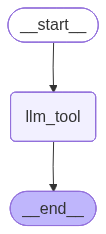

In [29]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)

builder.add_edge(START, "llm_tool")

builder.add_edge("llm_tool", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [30]:
## invovation

messages= graph.invoke({"messages":"what is 2 + 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 2 + 2
================================== Ai Message ==================================
Tool Calls:
  add (9j7dj4pzp)
 Call ID: 9j7dj4pzp
  Args:
    a: 2
    b: 2


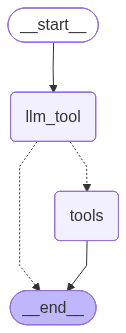

In [ ]:
from langgraph.prebuilt import  ToolNode, tools_condition

builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)

tools= [add]
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_tool")
builder.add_conditional_edges("llm_tool",tools_condition)

builder.add_edge("llm_tool", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))